## Preprocessing Aortic Root Segmentations for nnU-NEt

This notebook is designed to perform the preprocessing needed to generate aortic root segmentations with four labels: (1) sinotubular junction side of the root, (2) left ventricular outflow side of the root, (3) lumen, (4) interatrial septum. It was original used to generate datasets for nnUNet training but may be leveraged for other uses. The reason we are interested in these four labels is for streamlined alignment for shape analysis in the future. 
Start by ensuring your images are in LAS orientation and are named to your liking - see ______ for orientation and general file preprocessing. The input segmentations for the preprocessing must have the following in order to get the intended result of this package: (1) sinotubular junction band (label 6), (2) left ventricular outflow band (label 5), (3) general root label (label 4), and interatrial septum band (label 7). This is because labels 1 through 3 are reserved for cusp segmentations in our convention. 
Example below: 

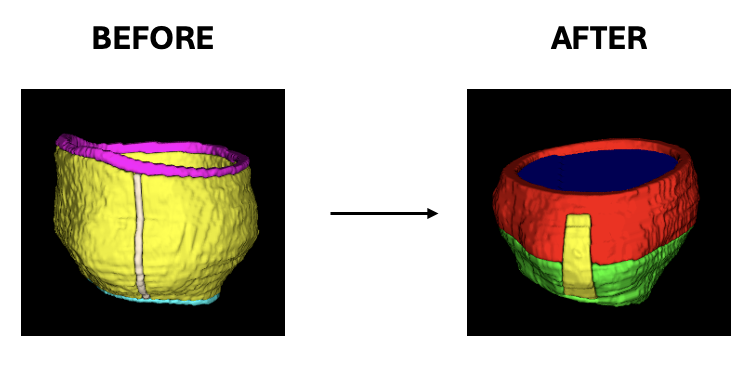

### Functions 

In [ ]:
import numpy as np
import nibabel as nib
from scipy.linalg import lstsq
from sklearn.decomposition import PCA
from skimage.morphology import flood_fill
import os
from scipy.ndimage import binary_dilation, binary_erosion
def holefillprocedure(data): 
    data[data ==7] = 4 
    copied_data = data.copy()
    stj_data = data.copy()
    stj_data[stj_data ==2] = 0
    stj_data[stj_data ==4] = 0
    lvo_data = data.copy()
    lvo_data[lvo_data ==1] = 0
    lvo_data[lvo_data ==4] = 0
    s = (3,3,3)
    dilated_stj = binary_dilation(stj_data==1, structure=np.ones(s), iterations =3)
    dilated_stj = dilated_stj.astype(data.dtype)
    eroded_stj = binary_erosion(dilated_stj==1, structure=np.ones(s), iterations=3)
    eroded_stj = eroded_stj.astype(data.dtype)
    dilated_lvo = binary_dilation(lvo_data==2, structure=np.ones(s), iterations =3)
    dilated_lvo = dilated_lvo.astype(data.dtype)
    eroded_lvo = binary_erosion(dilated_lvo==1, structure=np.ones(s), iterations=3)
    eroded_lvo = eroded_lvo.astype(data.dtype)
    eroded_lvo[eroded_lvo ==1] = 2
    
    copied_data[copied_data ==1] = 4
    copied_data[copied_data ==2] = 4
    dilated_data = binary_dilation(copied_data==4, structure=np.ones(s), iterations =3)
    dilated_data = dilated_data.astype(data.dtype)
    eroded_data = binary_erosion(dilated_data==1, structure=np.ones(s), iterations=3)
    eroded_data = eroded_data.astype(data.dtype)
    eroded_data[eroded_data ==1] = 4
    eroded_data[eroded_lvo==2] = 2 
    eroded_data[eroded_stj==1] = 1
    return eroded_data
def intensity_conversion(data):  
    data[data ==5] = 2
    data[data ==6]= 1
    return data
def stj_plane_coeffs(data):
    # Load the image using nibabel
    # Create meshgrid for the points in the image
    zz, yy, xx = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]), np.arange(data.shape[2]), indexing='ij')

    # Extract points where data == 1
    points = np.array([zz[data == 1], yy[data == 1], xx[data == 1]]).T

    # Perform PCA on the points to find the major and minor axes
    pca = PCA(n_components=2)
    pca.fit(points)

    # Center of the ellipse
    stj_center = pca.mean_

    # Directions of the major and minor axes
    major_axis_direction = pca.components_[0]
    minor_axis_direction = pca.components_[1]

    # Normal to the ellipse's plane
    normal = np.cross(major_axis_direction, minor_axis_direction)
    normal /= np.linalg.norm(normal)

    # D coefficient of the plane equation Ax + By + Cz + D = 0
    D = -np.dot(normal, stj_center)

    # Plane equation coefficients
    stj_coeffs = (*normal, D)

    return stj_coeffs, stj_center
def root_plane_coeffs(data):
    # Load the image using nibabel
    # Create meshgrid for the points in the image
    zz, yy, xx = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]), np.arange(data.shape[2]), indexing='ij')

    # Extract points where data == 1
    points = np.array([zz[data == 4], yy[data == 4], xx[data == 4]]).T

    # Perform PCA on the points to find the major and minor axes
    pca = PCA(n_components=2)
    pca.fit(points)

    # Center of the ellipse
    root_center = pca.mean_

    # Directions of the major and minor axes
    major_axis_direction = pca.components_[0]
    minor_axis_direction = pca.components_[1]

    # Normal to the ellipse's plane
    normal = np.cross(major_axis_direction, minor_axis_direction)
    normal /= np.linalg.norm(normal)

    # D coefficient of the plane equation Ax + By + Cz + D = 0
    D = -np.dot(normal, root_center)

    # Plane equation coefficients
    root_coeffs = (*normal, D)

    return root_coeffs, root_center

def seeds(data, stj_center):
    seed_x = int(max(0, min(stj_center[0], data.shape[0] - 1)))
    seed_y = int(max(0, min(stj_center[1], data.shape[1] - 1)))
    seed_z = int(max(0, min(stj_center[2], data.shape[2] - 1)))
    
    return seed_x, seed_y, seed_z  

def lvo_plane_coeffs(data):
    lvo = data == 2
    zz, yy, xx = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]), np.arange(data.shape[2]), indexing = 'ij')
    points = np.array([zz[data == 2], yy[data ==2], xx[data ==2]]).T
    pca = PCA(n_components=2)
    pca.fit(points)
    # center of the ellipse
    lvo_center = pca.mean_
    # directions of the major and minor axes
    major_axis_direction = pca.components_[0]
    minor_axis_direction = pca.components_[1]
    # normal normal to the ellipse's plane
    normal = np.cross(major_axis_direction, minor_axis_direction)
    normal /= np.linalg.norm(normal)
    # D coeff of the plane equation Ax + By + Cz + D = 0
    D = -np.dot(normal, lvo_center)
    # plane equation coefficients
    lvo_plane_coeffs = *normal, D
    return lvo_plane_coeffs, lvo_center

def root_plane_cutoff(data, stj_plane_coeffs, lvo_plane_coeffs, seed_x, seed_y, seed_z):
    mask = np.zeros(data.shape, dtype=bool)

    A, B, C, D = stj_plane_coeffs

    E, F, G, H = lvo_plane_coeffs
    
    if not (A*seed_x + B*seed_y + C*seed_z + D >= 0):
    # Invert the equation for the mask creation
        A, B, C, D = -A, -B, -C, -D

# Do the same for the lvo_plane
    if not (E*seed_x + F*seed_y + G*seed_z + H >= 0):
    # Invert the equation for the mask creation
        E, F, G, H = -E, -F, -G, -H
    #np.where(data ==4, mask == True, mask == False)
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            for z in range(data.shape[2]):
                # Evaluate the plane equation for the current voxel
                if A*x + B*y + C*z + D >= 0 and E*x + F*y + G*z + H >= 0:
                    # If the result is <= 0, the voxel is inside the mask
                    mask[x, y, z] = True
                    #np.where(data ==4, mask == True, mask == False)

    data[data==4] =1
    data[data==7] = 1
    data[data==2] = 1
    data[data==1] = 1

    combined_mask  = (data==1) & mask
    
    combined_mask = combined_mask.astype(int)
    background_value = 0

    #data[combined_mask] = 1
    filled_data = flood_fill(combined_mask, (seed_x, seed_y, seed_z), 3, connectivity=1)

    updated_segmentation = np.where((filled_data == 3), 3, data)
    updated_segmentation[~mask] = 0

    #updated_segmentation[~data] = 0

    updated_segmentation[updated_segmentation==1] = 0
    
    return updated_segmentation
    
    def save_nii(data, img):
        nii = nib.Nifti1Image(data, img.affine)
        nib.save(nii, 'segmentation.nii.gz')
        
def root_in_half_3(data, stj_plane_coeffs, lvo_plane_coeffs, root_plane_coeffs, root_center):   
    mask = np.zeros_like(data)
    data_copy = data.copy() 
    data_copy[data ==7]=4# Initialize mask to zeros, will only set where needed

    # Extract plane coefficients
    A, B, C, D = stj_plane_coeffs
    E, F, G, H = lvo_plane_coeffs
    I, J, K, L = root_plane_coeffs

    # Calculate seed coordinates
    seed_x = int(max(0, min(root_center[0], data.shape[0] - 1)))
    seed_y = int(max(0, min(root_center[1], data.shape[1] - 1)))
    seed_z = int(max(0, min(root_center[2], data.shape[2] - 1)))

    if not (A*seed_x + B*seed_y + C*seed_z + D >= 0):
    # Invert the equation for the mask creation
        A, B, C, D = -A, -B, -C, -D

# Do the same for the lvo_plane
    if not (E*seed_x + F*seed_y + G*seed_z + H >= 0):
    # Invert the equation for the mask creation
        E, F, G, H = -E, -F, -G, -H

    if not (I*seed_x + J*seed_y + K*seed_z + L >= 0):
    # Invert the equation for the mask creation
        I, J, K, L = -I, -J, -K, -L

    # Process each voxel
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            for z in range(data.shape[2]):
                if (A*x + B*y + C*z + D >= 0) and (I*x + J*y + K*z + L<= 0):  # Check between root and stj
                    if data_copy[x, y, z] in [1, 4]:  # Apply specific data conditions
                        mask[x, y, z] = 1
                if (E*x + F*y + G*z + H >= 0) and (I*x + J*y + K*z + L >= 0):  # Check between root and lvo
                    if data_copy[x, y, z] in [2, 4]:  # Apply specific data conditions
                        mask[x, y, z] = 2

    # Ensure background remains zero
    mask[data==1] = 1
    mask[data ==2] =2
    mask[data == 0] = 0
    mask[data ==7] = 4
    return mask
def march_ias_correction(data_ias):
    s = (5,5,5)
    dilated_ias = binary_dilation(data_ias==6, structure=np.ones(s), iterations =3)
    dilated_ias = dilated_ias.astype(data_ias.dtype)
    eroded_ias = binary_erosion(dilated_ias==1, structure=np.ones(s), iterations=3)
    eroded_ias = eroded_ias.astype(data_ias.dtype)
    eroded_ias[data_ias==0] = 0 
    eroded_ias[eroded_ias ==1] = 7
    data_ias[eroded_ias ==7] =7
    return data_ias
def march_ias_correction_test(data):
    s = (7, 7, 7)
    data_ias = data.copy()
    data_ias[(data_ias == 1) | (data_ias == 2) | (data_ias == 4)] = 0
    dilated_ias = binary_dilation(data_ias == 6, structure=np.ones(s), iterations=3)
    eroded_ias = binary_erosion(dilated_ias, structure=np.ones(s), iterations=3)

    # Update the original data where the eroded mask is true
    eroded_ias[data == 0] = 0
    data[eroded_ias] = 7
    
    return data
from operator import sub
def root_in_half_4(data, stj_plane_coeffs, lvo_plane_coeffs, root_plane_coeffs, root_center):   
    mask = np.zeros_like(data)
    data_copy = data.copy() 
    data_copy[data == 7] = 4  # Initialize mask to zeros, will only set where needed

    # Extract plane coefficients
    A, B, C, D = stj_plane_coeffs
    E, F, G, H = lvo_plane_coeffs
    I, J, K, L = root_plane_coeffs


    com_stj = calc_com_3d_reduced_dimension(data == 1)
    com_lvo = calc_com_3d_reduced_dimension(data == 2)
    com_root = calc_com_3d_reduced_dimension(data == 4)
    
    seed_x = int(max(0, min(root_center[0], data.shape[0] - 1)))
    seed_y = int(max(0, min(root_center[1], data.shape[1] - 1)))
    seed_z = int(max(0, min(root_center[2], data.shape[2] - 1)))

    stj_to_lvo =  np.array(com_stj) - np.array(com_lvo)
    normal_root = np.array([I, J, K])
    if np.dot(stj_to_lvo, normal_root) > 0: 
        I, J, K, L = -I, -J, -K, -L  

   
    if np.dot(np.array([A, B, C]), normal_root) < 0:
        A, B, C, D = -A, -B, -C, -D
    if np.dot(np.array([E, F, G]), normal_root)< 0:
        E, F, G, H = -E, -F, -G, -H
        
    print(f"stj {np.dot(np.array([A,B,C]), normal_root)}")
    print(f"lvo {np.dot(np.array([E,F,G]), normal_root)}")
    


    # Process each voxel
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            for z in range(data.shape[2]):
                if  I*x + J* y + K*z + L<= 0:  # Check between root and stj
                    if data_copy[x, y, z] in [1, 4]:  # Apply specific data conditions
                        mask[x, y, z] = 1
                if I*x + J* y + K*z + L>= 0:  # Check between root and lvo
                    if data_copy[x, y, z] in [2, 4]:  # Apply specific data conditions
                        mask[x, y, z] = 2

    # Ensure background remains zero
    mask[data == 1] = 1
    mask[data == 2] = 2
    mask[data == 0] = 0
    mask[data == 7] = 4
    return mask

def calc_com_3d_reduced_dimension(data):
    assert len(data.shape) == 3
    new_data = data
    dup_mask = data[:,:,:]>0   #Normalize segmentations to binary mask, any signal gets included in com calculation
    xsum = np.sum(np.sum(dup_mask, axis=1), axis=1)
    ysum = np.sum(np.sum(dup_mask, axis=0), axis=1)
    zsum = np.sum(np.sum(dup_mask, axis=0), axis=0)

    # plt.plot(range(len(xsum)), xsum)
    # plt.plot(range(len(ysum)), ysum)
    # plt.plot(range(len(zsum)), zsum)

    def calc_com_1d(arr):
        wsum = 0
        msum = 0
        for i in range(len(arr)):
            wsum += arr[i]*i
            msum += arr[i]
        if msum == 0:
            return int((len(arr)+1)/2)
        return wsum/msum

    xcom = calc_com_1d(xsum)
    ycom = calc_com_1d(ysum)
    zcom = calc_com_1d(zsum)
    return (int(xcom), int(ycom), int(zcom))
def refine_segmentation(data, root_plane_coeffs):
    initial_mask = data.copy()
    initial_mask[initial_mask == 7] = 4  # Initialize mask to zeros, will only set where needed

    com_stj = calc_com_3d_reduced_dimension(initial_mask == 1)
    com_lvo = calc_com_3d_reduced_dimension(initial_mask == 2)
    com_root = calc_com_3d_reduced_dimension(initial_mask == 4)
    com_z = int(com_root[2])
    I, J, K, L = root_plane_coeffs
    normal_root = np.array([I, J, K])
    
    if np.dot(normal_root, [0, 0, 1]) < 0:  # Assuming z-axis is from inferior to superior
        I, J, K, L = -I, -J, -K, -L
    # Refine boundaries based on proximity to each center of mass
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            for z in range(data.shape[2]):
                if initial_mask[x, y, z] in [1, 2, 4]:  # Only adjust for these classes
                    point = np.array([x, y, z])
                    dist_stj = np.linalg.norm(point - com_stj)
                    dist_lvo = np.linalg.norm(point - com_lvo)
                    dist_root = np.linalg.norm(point - com_root)
                    # Reassign based on proximity
                    if np.abs(dist_stj - dist_root) < np.abs(dist_lvo - dist_root) and I*x+ J*y + K*z + L <= 0:
                        initial_mask[x, y, z] = 1
                    else:
                        initial_mask[x, y, z] = 2

                    
        
    
    # Optionally apply morphological operations
    initial_mask[data == 1] = 1
    initial_mask[data == 2] = 2
    initial_mask[data == 0] = 0
    initial_mask[data == 7] = 4

    return initial_mask
def root_plane_cut(data, root_coeffs):
    mask = data.copy()
    


    I, J, K, L = root_coeffs
    normal_root = np.array([I, J, K])
    if np.dot(normal_root, [0, 0, 1]) < 0:  # Assuming z-axis is from inferior to superior
        I, J, K = -I, -J, -K
    

    #np.where(data ==4, mask == True, mask == False)
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            for z in range(data.shape[2]):
                # Evaluate the plane equation for the current voxel
                if I*x + J*y + K*z + L <= 0:
                    if data[x, y, z] in [1, 4]:
                        mask[x, y, z] = 1
                if I*x + J*y + K*z + L >= 0:
                    if data[x, y, z] in [2, 4]:
                        mask[x, y, z] = 2
                
                     
    mask[data == 1] = 1 
    mask[data ==2] =2 
    mask[data == 7] = 4
    mask[data == 0] = 0
    
    return mask

### Execution

In [ ]:
##Step 1 - negate image, perform holefill and save result
files = os.listdir('/path/to/input_segmentations/')
for f in files: 
    print(f"starting {f}")
    img_og = nib.load('/path/to/input_segmentation' + '/' + f)
    data_og = img_og.get_fdata()
    if data_og.max() == 6:
        data_og[data_og ==6] = 7
    data = intensity_conversion(data_og)
    holefilled_data = holefillprocedure(data_og)
    root_coeffs, root_center = root_plane_coeffs(data_og)
    stj_coeffs, stj_center = stj_plane_coeffs(data_og)
    lvo_coeffs, lvo_center = lvo_plane_coeffs(data_og)
    seed_x, seed_y, seed_z = seeds(data_og, root_center)
    planefilleddata = root_plane_cutoff(holefilled_data, stj_coeffs, lvo_coeffs, seed_x, seed_y, seed_z)
    s= (5,5,5)
    planefilleddata = binary_erosion((planefilleddata== 3), structure=np.ones(s), iterations=1)
    planefilleddata = planefilleddata.astype(data_og.dtype)
    planefilleddata[holefilled_data != 0] =0
    
    nii = nib.Nifti1Image(planefilleddata, img_og.affine)
    nib.save(nii, f'/path/to/destination_segmentations/{f}')


In [ ]:
#Step 2 - perform connected components and save the second connected component
""" Run in terminal: 

Step 2 is to use connected components to retrieve the second connected component - I like using the ITKSnap commandline tool for this (c3d). You may run the ____ script to do this. 
Below is a snippet as well: 
segmentation_dir="/path/to/destination_segmentations"
destination_path="/path/to/newintermediatedestination"


#Loop through each image in the image directory
    for image in "$segmentation_dir"/*.nii.gz; do
        study_id=$(basename "$image" | cut -c 7-12)
        frame_number=$(basename "$image" | cut -c 4-5)  # adjust 'n' to extract frame number correctly
        # Construct the segmentation filename
        segmentation="$segmentation_dir/img${frame_number}_${study_id}.nii.gz"  # Adjust this pattern as needed
        echo "Processing $image"
        # Check if the segmentation file exists
        if [ -f "$segmentation" ]; then
            # Use c3d to trim the image based on the segmentation
            # (Adjust the c3d command according to your specific requirements)
            c3d "$segmentation" -comp -threshold 2 2 3 0 -o "$destination_path/img${frame_number}_${study_id}.nii.gz"
        else
            echo "Segmentation not found for $image"
        fi
        done
        
        """

In [ ]:
#Step 3 - perform dilation and erosion on the second connected component and add root/stj/lvo labels back to the image
filepath1 = os.listdir('/path/to/newintermediatedestination')
filepath2 = os.listdir('/path/to/original_segmentations')

for file in filepath1: 
    for f in filepath2: 
        if f == file: 
            print(f"processing {file} now")
            img = nib.load('/path/to/newintermediatedestination' + file)
            data = img.get_fdata()
            img2 = nib.load('/path/to/original_segmentations' + f)
            data2 = img2.get_fdata()
            s = (3,3,3)
            data_dilated = binary_dilation(data==3, structure= np.ones(s), iterations = 3)
            data_dilated = data_dilated.astype(data.dtype)
            data_dilated[(data2 ==1)|(data2==2)|(data2==4)|(data2==6)] = 0
            data2[data2==6] =7
            data_dilated[(data_dilated ==1)] = 3
            data_dilated = data_dilated + data2 


            nii = nib.Nifti1Image(data_dilated, img.affine)
            nib.save(nii, '/path/to/newintermediatedestination' + file)
            print(f"finished {file} now")

In [ ]:
#Step 4 - divide root label in stj and lvo
filepath1 = os.listdir('/path/to/newintermediatedestination')
filepath2 = os.listdir('/path/to/input_segmentations')
for file in filepath1:
    for f in filepath2: 
        if file == f: 
            img = nib.load('/path/to/newintermediatedestination'+ file)
            data = img.get_fdata()
            img_og = nib.load('/path/to/input_segmentations' + file)
            data_og = img_og.get_fdata()
            data_og = intensity_conversion(data_og)
            root_coeffs, root_center = root_plane_coeffs(data_og)
            stj_coeffs, stj_center = stj_plane_coeffs(data_og)
            lvo_coeffs, lvo_center = lvo_plane_coeffs(data_og)
            dataagain = root_in_half_4(data_og, stj_coeffs, lvo_coeffs, root_coeffs, root_center)
            data[(dataagain == 1)] = 1
            data[(dataagain == 2)] = 2
            data[data ==7] = 4
            nii = nib.Nifti1Image(data, img.affine)
            nib.save(nii, '/path/to/final/destation' + file)
            print(f"finishing {file} now")

